In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing

In [ ]:
# Instead of importing from keras.preprocessing.text, import from tensorflow.keras.preprocessing.text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from nltk.tokenize import RegexpTokenizer
import numpy as np
import re
import pandas as pd
from sklearn.model_selection import train_test_split


In [ ]:
import os

In [ ]:
os.chdir( "/content/drive/My Drive/PES_MTech_inperson/S3_S4")

### Load the dataset from the disk

In [ ]:
import pandas as pd
df = pd.read_csv('complaints.csv') # We are taking less rows for faster execution
df.head()

,Consumer complaint narrative,Product
0,I have outdated information on my credit repor...,Credit reporting
1,I purchased a new car on XXXX XXXX. The car de...,Consumer Loan
2,An account on my credit report has a mistaken ...,Credit reporting
3,This company refuses to provide me verificatio...,Debt collection
4,This complaint is in regards to Square Two Fin...,Debt collection


In [ ]:
df.shape

(179776, 2)

In [ ]:
df['Product'].value_counts()

,count
Product,
Debt collection,43946
Mortgage,34576
Credit reporting,31589
Credit card,18845
Bank account or service,14892
Student loan,12047
Consumer Loan,9486
"Credit reporting, credit repair services, or other personal consumer reports",6118
Payday loan,1750


<Axes: xlabel='Product'>

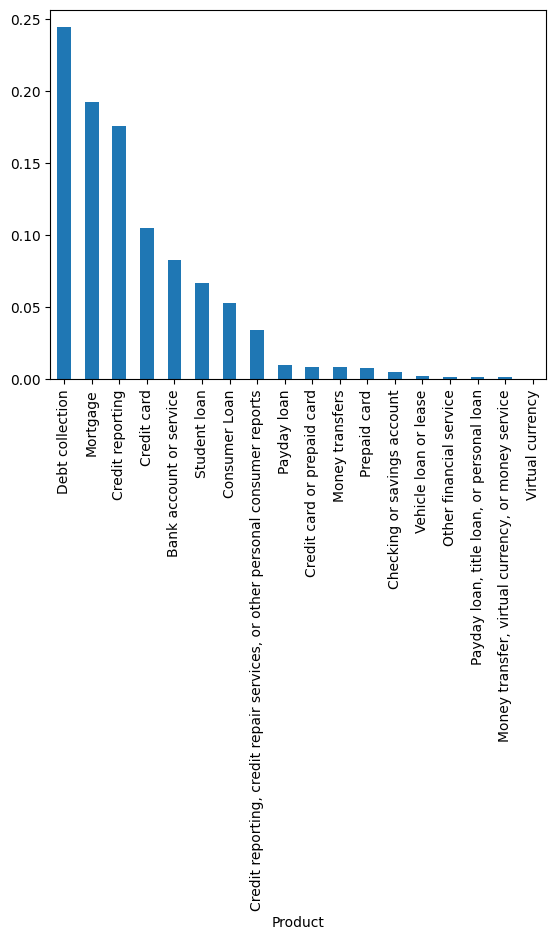

In [ ]:
df['Product'].value_counts(normalize=True).plot(kind='bar')

In [ ]:
stratify_column = 'Product'

In [ ]:
df_prod, _=train_test_split(df, test_size=0.75, stratify=df[stratify_column], random_state=42)

In [ ]:
df.shape

(179776, 2)

In [ ]:
df_prod.shape

(44944, 2)

<Axes: xlabel='Product'>

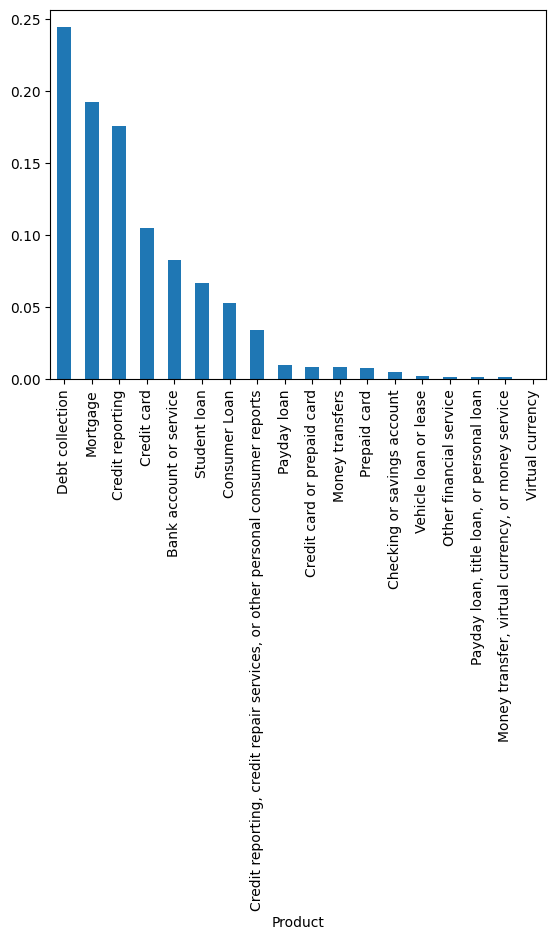

In [ ]:
df_prod['Product'].value_counts(normalize=True).plot(kind='bar')

In [ ]:
threshold=0.05

In [ ]:
values_below_threshold = df_prod['Product'].value_counts(normalize=True)
values_below_threshold = values_below_threshold[df_prod['Product'].value_counts(normalize=True) <=threshold ].index.tolist()

In [ ]:
values_below_threshold

['Credit reporting, credit repair services, or other personal consumer reports',
 'Payday loan',
 'Credit card or prepaid card',
 'Money transfers',
 'Prepaid card',
 'Checking or savings account',
 'Vehicle loan or lease',
 'Other financial service',
 'Payday loan, title loan, or personal loan',
 'Money transfer, virtual currency, or money service',
 'Virtual currency']

In [ ]:
len(values_below_threshold)

11

In [ ]:
df_prod['Product'] = df_prod['Product'].apply(lambda x: 'Other' if x in values_below_threshold else x)

<Axes: xlabel='Product'>

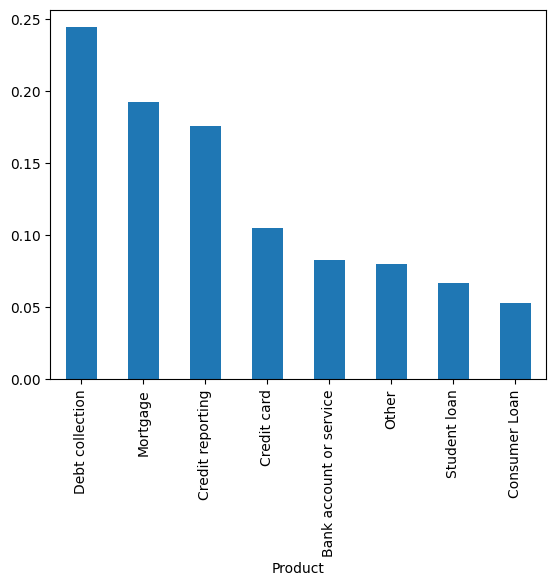

In [ ]:
df_prod['Product'].value_counts(normalize=True).plot(kind='bar')

In [ ]:
df_prod.isnull().sum()

,0
Consumer complaint narrative,0
Product,0


### Tokenizer
Regular expression based tokenizers to consider only alphabetical sequences and ignore numerical sequences.

In [ ]:
def cleanup(text):

    #words = comp.lower().split()
    alphabets_only = re.sub("[^a-zA-Z\s]", "", text) # Remove non-alphabetic characters
    alphabets_only = re.sub("\d+", "", alphabets_only)  # Remove digits explicitly
    alphabets_only = re.sub("\s+", " ", alphabets_only).strip() # Remove extra spaces
    return alphabets_only.lower()

In [ ]:
df_prod['Consumer complaint narrative']=df_prod['Consumer complaint narrative'].apply(cleanup)

### Vocabulary
Extracing all the unique words from the dataset

In [ ]:
def complaint_to_words(text) -> list:
    return text.split()

In [ ]:
all_words = list()
for comp in df_prod['Consumer complaint narrative']:
    for w in complaint_to_words(comp):
        all_words.append(w)

In [ ]:
print('Size of vocabulary: {}'.format(len(set(all_words))))

Size of vocabulary: 47743


In [ ]:
print('Complaint\n', df_prod['Consumer complaint narrative'].iloc[10], '\n')
print('Tokens\n', complaint_to_words(df_prod['Consumer complaint narrative'].iloc[10]))

Complaint
 my credit has been in consumer affairs department with equifax since they claim they protecting my identity but this not only effecting me but it is effecting my family i cant purchase a home because there are accounts on my credit from identity theft i have proof of the accounts previous being deleted also it is effecting me with irs because they have businesses reporting income that i have no clue who they are from and it is spilling over from my credit to irs 

Tokens
 ['my', 'credit', 'has', 'been', 'in', 'consumer', 'affairs', 'department', 'with', 'equifax', 'since', 'they', 'claim', 'they', 'protecting', 'my', 'identity', 'but', 'this', 'not', 'only', 'effecting', 'me', 'but', 'it', 'is', 'effecting', 'my', 'family', 'i', 'cant', 'purchase', 'a', 'home', 'because', 'there', 'are', 'accounts', 'on', 'my', 'credit', 'from', 'identity', 'theft', 'i', 'have', 'proof', 'of', 'the', 'accounts', 'previous', 'being', 'deleted', 'also', 'it', 'is', 'effecting', 'me', 'with', '

In [ ]:
df_prod.sample(10)

,Consumer complaint narrative,Product
156673,under public records i have a case filed with ...,Credit reporting
161305,i did a little research on repossession of veh...,Consumer Loan
79590,i took out a loan from xxxx xxxx last year and...,Consumer Loan
56446,i decided to check my reports from all credit ...,Other
161863,i have a penny mac online user id for my month...,Mortgage
30892,private bank of xxxx refused to share the appr...,Mortgage
175999,xxxx is collecting an account for xxxx i have ...,Other
117930,i wrote a check in the amount of xxxx check nu...,Bank account or service
50163,xxxx paid off our federal student loan than we...,Student loan
18563,i was sued by xxxx for foreclosure in i wrote ...,Mortgage


In [ ]:
df_train=df_prod.sample(frac=0.9,random_state=50)
df_test=df_prod.drop(df_train.index)

Label encode data


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_prod['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 47743 unique tokens.


In [ ]:
print (word_index)

{'xxxx': 1, 'the': 2, 'i': 3, 'to': 4, 'and': 5, 'a': 6, 'my': 7, 'of': 8, 'that': 9, 'was': 10, 'they': 11, 'in': 12, 'on': 13, 'have': 14, 'not': 15, 'this': 16, 'for': 17, 'me': 18, 'is': 19, 'with': 20, 'it': 21, 'credit': 22, 'account': 23, 'from': 24, 'as': 25, 'had': 26, 'be': 27, 'them': 28, 'loan': 29, 'would': 30, 'payment': 31, 'by': 32, 'we': 33, 'are': 34, 'been': 35, 'an': 36, 'at': 37, 'or': 38, 'xxxxxxxx': 39, 'no': 40, 'has': 41, 'but': 42, 'bank': 43, 'do': 44, 'did': 45, 'told': 46, 'debt': 47, 'report': 48, 'all': 49, 'nt': 50, 'information': 51, 'which': 52, 'am': 53, 'when': 54, 'were': 55, 'received': 56, 'their': 57, 'any': 58, 'time': 59, 'you': 60, 'so': 61, 'card': 62, 'called': 63, 'company': 64, 'after': 65, 'mortgage': 66, 's': 67, 'if': 68, 'never': 69, 'payments': 70, 'because': 71, 'pay': 72, 'out': 73, 'can': 74, 'will': 75, 'sent': 76, 'get': 77, 'there': 78, 'our': 79, 'back': 80, 'call': 81, 'letter': 82, 'paid': 83, 'up': 84, 'then': 85, 'she': 86,

In [ ]:
X_pre = tokenizer.texts_to_sequences(df_prod['Consumer complaint narrative'].values)

In [ ]:
strng= df_prod['Consumer complaint narrative'].iloc[0]
print (strng)
print (len(strng.split()))

my student loans have been discharged by the department of education due to xxxx i now no longer owe anything on these accounts these accounts should read as closed with xxxx balance here are the account numbers xxxx account xxxx and xxxx accounts with department of education xxxx all with account xxxx equifax refuses to make the adjustment
58


In [ ]:
np.array(X_pre[0])

array([   7,  316,  146,   14,   35,  915,   32,    2,  263,    8, 1018,
         97,    4,    1,    3,   89,   40,  428,  220,  246,   13,  117,
        133,  117,  133,  115,  870,   25,  206,   20,    1,  105,  551,
         34,    2,   23,  524,    1,   23,    1,    5,    1,  133,   20,
        263,    8, 1018,    1,   49,   20,   23,    1,  213,  811,    4,
        121,    2, 2065])

In [ ]:
print(len(X_pre[0]))

58


In [ ]:
comp_len=df_prod['Consumer complaint narrative'].apply(lambda x: len(x.split())).to_list()

In [ ]:
np.median(comp_len)

132.0

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = len(word_index)
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = int(np.median(comp_len))
# This is fixed.
EMBEDDING_DIM = 300

In [ ]:
MAX_SEQUENCE_LENGTH


132

In [ ]:
X = pad_sequences(X_pre, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
print(X[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    7  316  146   14   35  915   32    2  263    8
 1018   97    4    1    3   89   40  428  220  246   13  117  133  117
  133  115  870   25  206   20    1  105  551   34    2   23  524    1
   23    1    5    1  133   20  263    8 1018    1   49   20   23    1
  213  811    4  121    2 2065]


In [ ]:
print (len(X[0]))

132


In [ ]:
Y = pd.get_dummies(df_prod['Product']).values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(35955, 132) (35955, 8)
(8989, 132) (8989, 8)


In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(8, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20
batch_size = 64

history = model_lstm.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001)])

Epoch 1/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.4042 - loss: 1.6297 - val_accuracy: 0.5381 - val_loss: 1.3755
Epoch 2/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5691 - loss: 1.2589 - val_accuracy: 0.6199 - val_loss: 1.1729
Epoch 3/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7015 - loss: 0.9169 - val_accuracy: 0.6849 - val_loss: 0.9844
Epoch 4/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7737 - loss: 0.7019 - val_accuracy: 0.7036 - val_loss: 0.9443
Epoch 5/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8198 - loss: 0.5806 - val_accuracy: 0.7225 - val_loss: 0.9472
Epoch 6/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8593 - loss: 0.4637 - val_accuracy: 0.7230 - val_loss: 0.9453
Epoch 7/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8906 - loss: 0.3751 - val_accuracy: 0.6991 - val_loss: 1.0464
Epoch 8/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9114 - loss: 0.3068 - val_acc

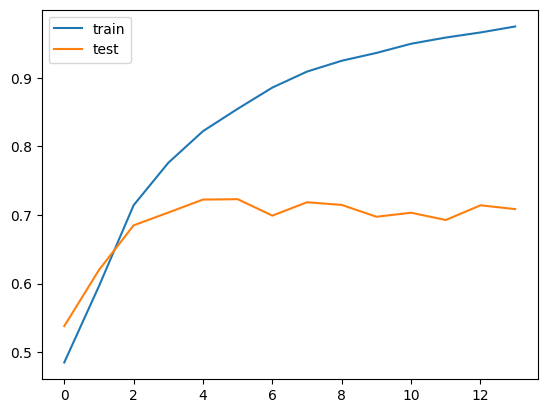

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.layers import TimeDistributed, Flatten

In [ ]:
model_lstm2 = Sequential()
model_lstm2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM))
model_lstm2.add(LSTM(4, return_sequences=True, recurrent_dropout=0.5))  # Output a sequence for each timestep
model_lstm2.add(LSTM(2, return_sequences=True, recurrent_dropout=0.5)) # Output only the final timestep's output
model_lstm2.add(Flatten())
#model_lstm2.add(TimeDistributed(Dense(units=64, activation='relu')))
model_lstm2.add(Dense(64, activation='relu'))
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Dense(8, activation='softmax'))
model_lstm2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model_lstm2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001)])

Epoch 1/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 145s 280ms/step - accuracy: 0.3505 - loss: 1.7310 - val_accuracy: 0.6112 - val_loss: 1.1246
Epoch 2/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 142s 281ms/step - accuracy: 0.6409 - loss: 1.0742 - val_accuracy: 0.6688 - val_loss: 1.0067
Epoch 3/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 141s 279ms/step - accuracy: 0.7098 - loss: 0.8848 - val_accuracy: 0.6582 - val_loss: 1.0356
Epoch 4/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 140s 277ms/step - accuracy: 0.7617 - loss: 0.7325 - val_accuracy: 0.6649 - val_loss: 1.0721
Epoch 5/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 140s 276ms/step - accuracy: 0.7949 - loss: 0.6263 - val_accuracy: 0.6599 - val_loss: 1.1822
Epoch 6/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 139s 276ms/step - accuracy: 0.8228 - loss: 0.5391 - val_accuracy: 0.6474 - val_loss: 1.2606
Epoch 7/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 140s 277ms/step - accuracy: 0.8402 - loss: 0.4876 - val_accuracy: 0.6354 - val_loss: 1.4798
Epoch 8/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 139s 275ms/step - accuracy: 0.8632 -

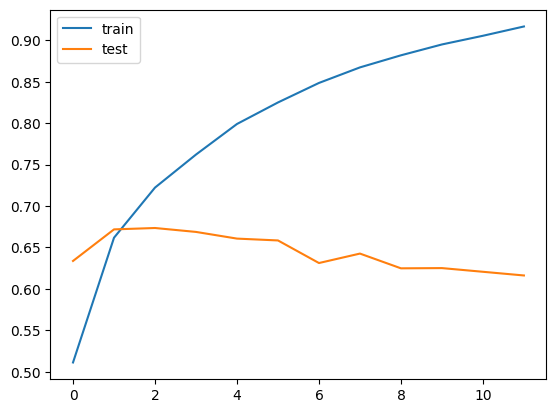

In [ ]:
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='test')
plt.legend()
plt.show()